# **Business case 4: Anomaly Detection**

### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import tensorflow as tf
import random
import warnings
import os
import sys

from keras import backend as K
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from pyod.models.copod import COPOD


tfk = tf.keras
tfkl = tf.keras.layers
seed = 33
tf.random.set_seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED']=str(seed)
tf.compat.v1.set_random_seed(seed)

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

2025-05-13 14:14:21.288156: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 1) Features

### Data Exploration

In [2]:
# Reading dataframe from excel file
df = pd.read_excel('Dataset4_EWS.xlsx')
df.head()

,Data,BDIY,CRY,Cl1,DXY,ECSURPUS,EMUSTRUU,EONIA,GBP,GT10,...,MXJP,MXRU,MXUS,US0001M,USGG2YR,USGG30YR,USGG3M,VIX,XAUBGNL,Y
0,2000-01-11,1388,157.26,25.77,100.56,0.077,230.5267,2.89,1.6460,6.657,...,990.59,224.33,1416.12,5.78125,6.428,6.671,5.426,22.50,283.25,0
1,2000-01-18,1405,165.01,28.85,101.86,0.043,231.3770,3.03,1.6383,6.748,...,993.98,234.37,1428.79,5.80250,6.465,6.747,5.378,21.50,287.65,0
2,2000-01-25,1368,167.24,28.28,102.41,0.135,232.3895,3.15,1.6496,6.692,...,974.83,216.82,1385.93,5.81875,6.432,6.634,5.562,23.02,287.15,0
3,2000-02-01,1311,166.85,28.22,104.92,0.191,231.9417,3.30,1.6106,6.619,...,1007.12,201.89,1385.31,5.88500,6.574,6.423,5.708,23.45,282.75,0
4,2000-02-08,1277,165.43,28.02,104.22,0.312,237.8117,3.26,1.6108,6.613,...,1034.58,218.00,1411.95,5.89125,6.678,6.231,5.677,21.25,298.40,1


In [3]:
# Reading dataframe from excel file
df1 = pd.read_excel('Dataset4_EWS.xlsx')
df1.drop(labels = 'Data', axis = 1, inplace = True)

<Axes: >

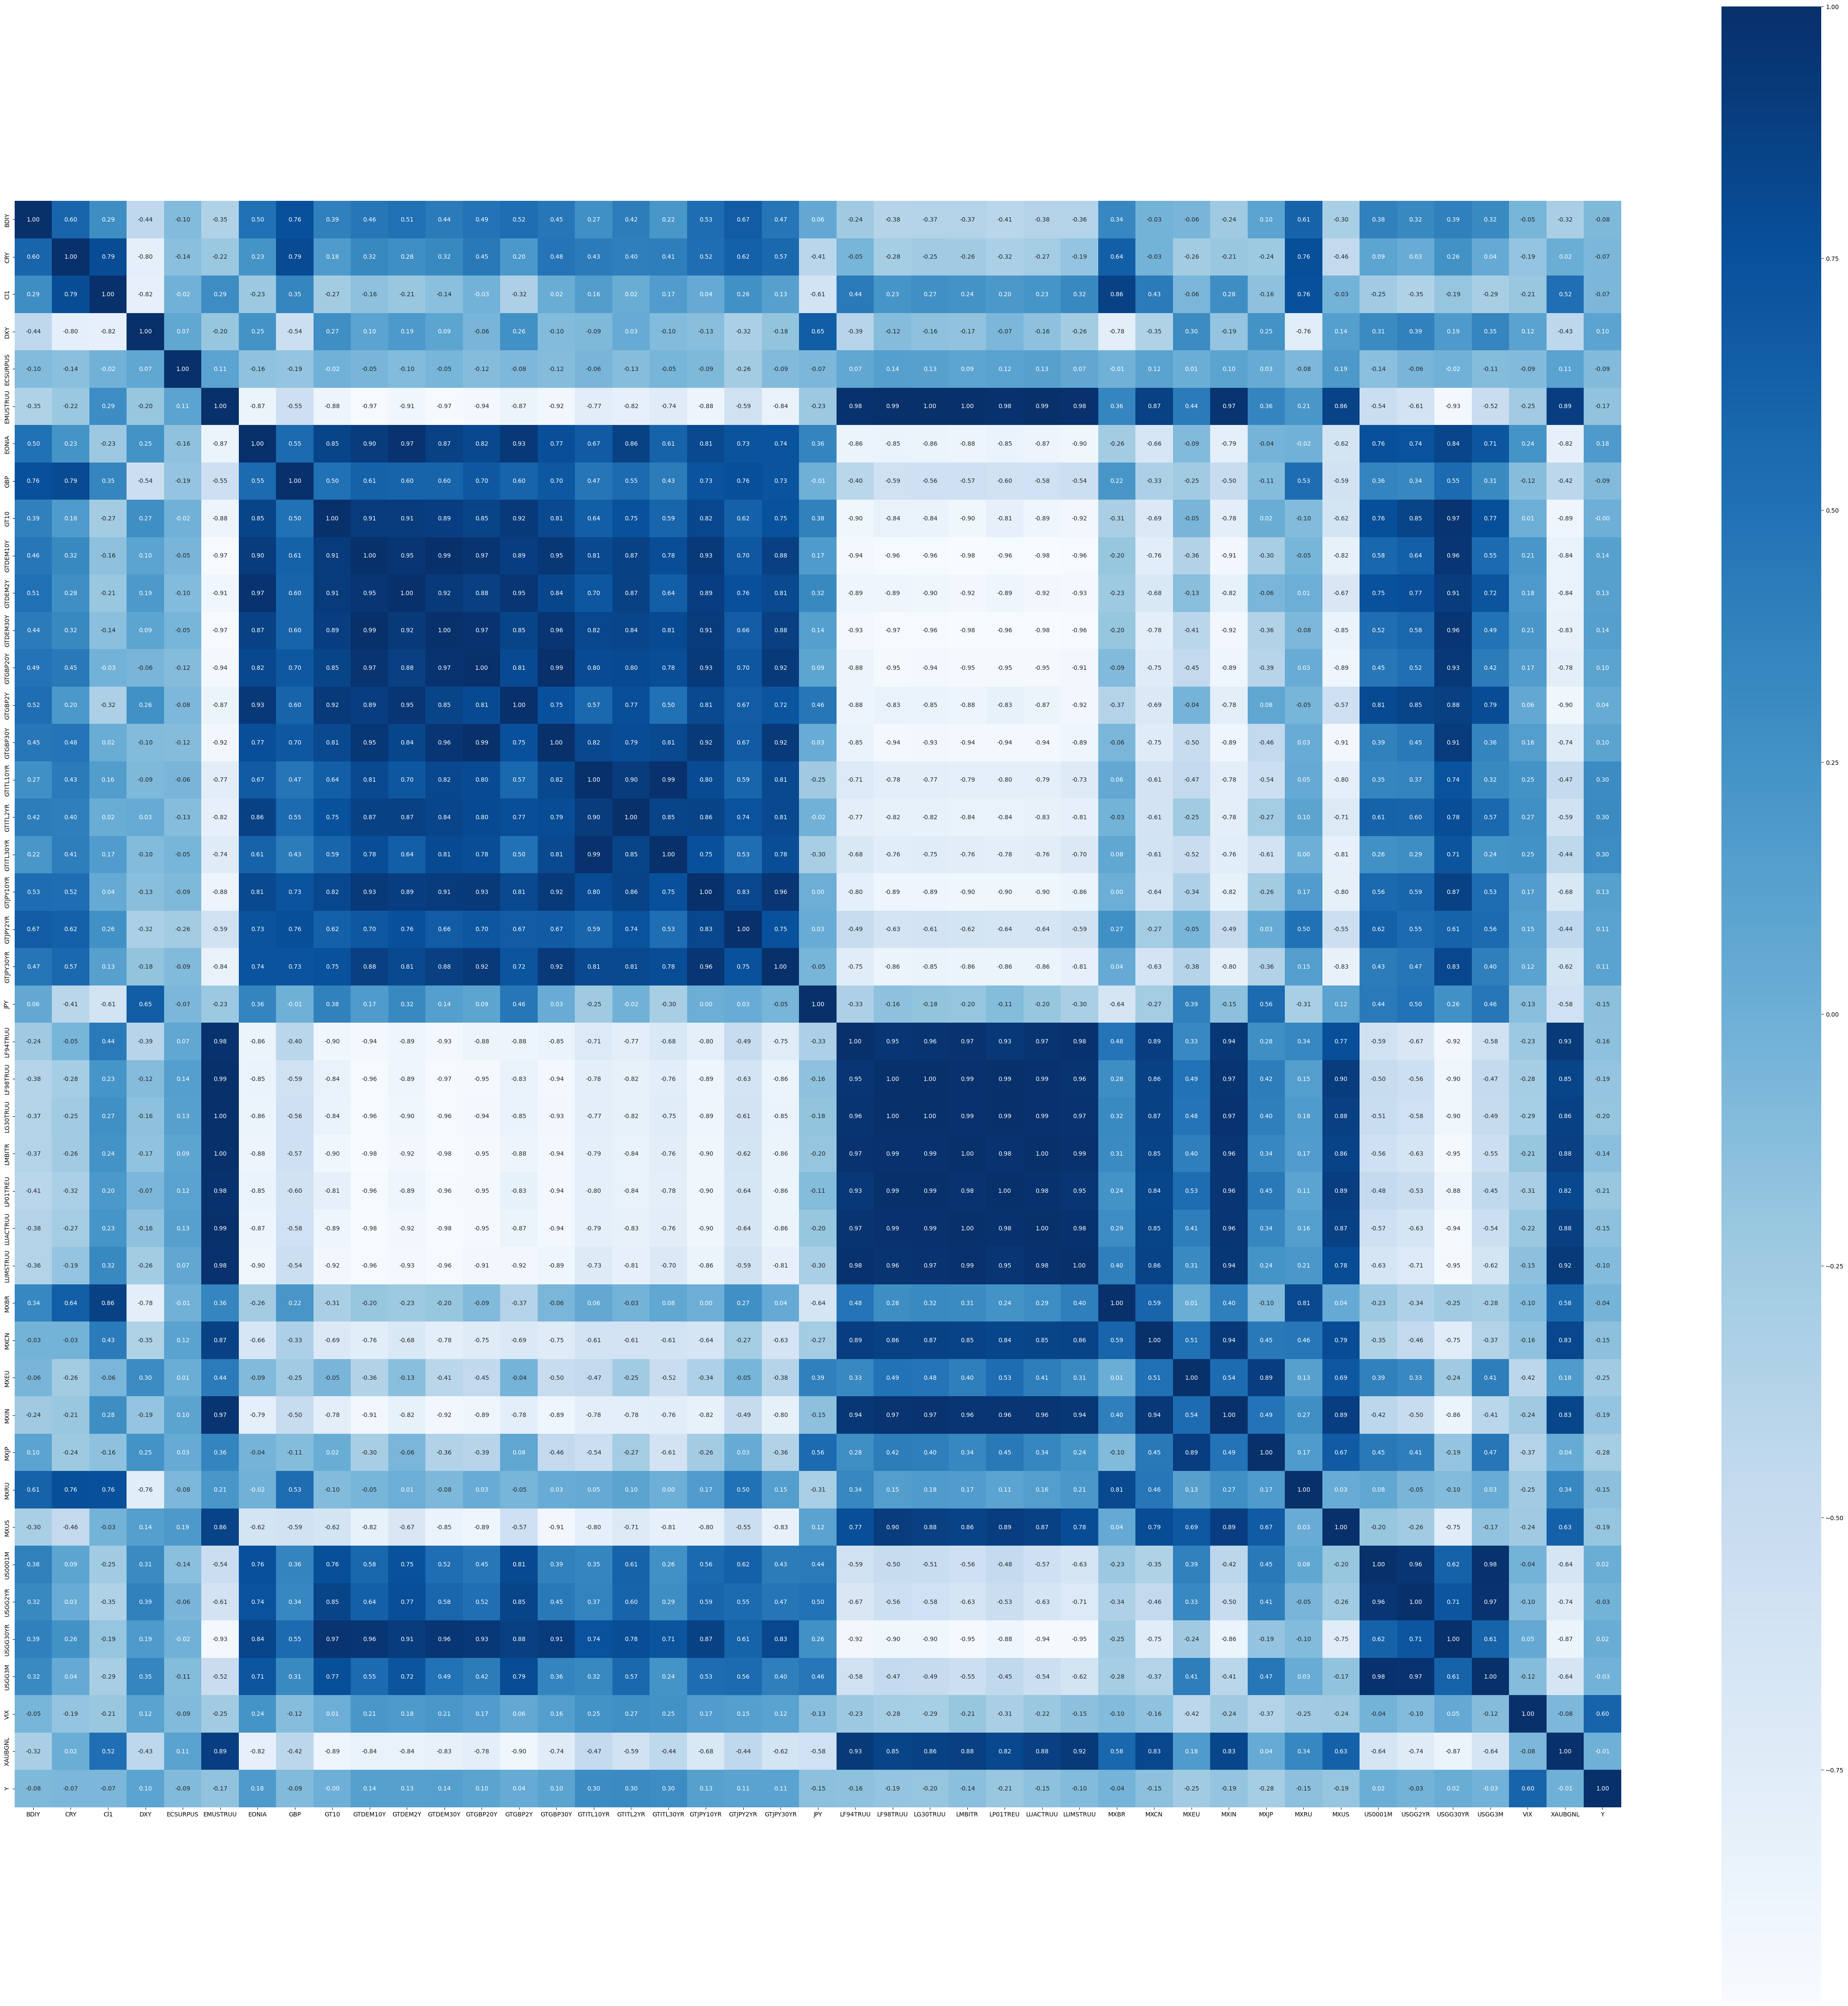

In [4]:
# plot the correlation matrix
#df1.drop(labels = 'Y', axis = 1, inplace = True)
corrmat = df1.corr()
plt.figure(figsize=(60, 60))
sns.heatmap(corrmat,
            cbar=True,
            annot=True,
            square=True,
            cmap="Blues",
            fmt='.2f',
            annot_kws={'size': 10},
            yticklabels=df1.columns,
            xticklabels=df1.columns)

In [5]:
def FindCorrFeature(X):
  corr_features = set()
  for i in range(len(X.columns)):
    for j in range(i):
        if abs(X.iloc[i, j]) > 0.9:
            col = X.columns[i]
            corr_features.add(col)
            col2 = X.columns[j]
            corr_features.add(col2)

  return corr_features

In [6]:
correlated_features= FindCorrFeature(corrmat)
print(correlated_features)

{'US0001M', 'MXIN', 'EMUSTRUU', 'LF98TRUU', 'LP01TREU', 'MXCN', 'MXUS', 'GTGBP20Y', 'XAUBGNL', 'GTITL10YR', 'GTITL2YR', 'USGG3M', 'GTDEM30Y', 'EONIA', 'LUACTRUU', 'GTDEM2Y', 'GTGBP30Y', 'LG30TRUU', 'LUMSTRUU', 'GTGBP2Y', 'LF94TRUU', 'GTITL30YR', 'LMBITR', 'GT10', 'GTJPY10YR', 'GTDEM10Y', 'USGG30YR', 'GTJPY30YR', 'USGG2YR'}


### Data Preprocessing

Following the data exploration phase, we have implemented several modifications to the original dataset:

- **Transformation to Weekly Returns**
All features, excluding index and label data, have been converted into weekly returns. This transformation ensures a consistent scale across variables and promotes stationarity, which is essential for many statistical and machine learning models.

- **Feature Selection**
To reduce redundancy, highly correlated features—those providing overlapping information—have been removed. The final feature set includes:
Cl1: Reflects commodity market trends and helps identify sector-specific patterns.
MXCN, MXEU, MXJP, MXUS: Represent equity indices from China, Europe, Japan, and the USA. Sudden movements may signal regional or global market anomalies.
VIX: Measures expected market volatility based on S&P 500 options. Spikes in VIX often indicate rising uncertainty or major events.
GT10: The 10-year U.S. Treasury yield, a key indicator of bond market sentiment and economic expectations.
ECSURPUS: Surplus capital within the insurance sector. Significant fluctuations may highlight financial stress or unusual investment activity.
SP_GOLD: The newly added feature capturing risk sentiment through the equity/gold performance ratio.
In summary, the selected features provide comprehensive insights into market dynamics, including equity and commodity trends, volatility expectations, bond market shifts, and systemic risk indicators.

- **Introduction of SP_GOLD (S&P 500 / XAUBGNL)**
A new feature, SP_GOLD, has been added to capture the relative performance of equities versus gold. The S&P 500 serves as a benchmark for the overall health of the U.S. stock market and typically rises during periods of strong investor confidence. In contrast, gold (XAUBGNL) is regarded as a safe-haven asset and tends to appreciate during periods of economic uncertainty or market volatility. The SP_GOLD ratio provides a composite indicator of market sentiment, where an increasing ratio suggests a shift toward risk-on behavior, reflecting the outperformance of equities over gold.


In [7]:
import pandas as pd
import yfinance as yf

def add_sp_gold(df):
    # Convert 'Data' to datetime (handle DD-MM-YYYY format)
    df['Data'] = pd.to_datetime(df['Data'], format='%d-%m-%Y')

    # Define start and end dates
    start_date = df['Data'].iloc[0].strftime('%Y-%m-%d')
    end_date = df['Data'].iloc[-1].strftime('%Y-%m-%d')

    # Download S&P500 weekly data
    sp500 = yf.download('^GSPC', start=start_date, end=end_date, interval='1wk')
    sp500 = sp500[['Close']].reset_index()
    sp500.columns = ['Data', 'SP500']  # rename for clean merge

    # Ensure 'Data' in both is datetime (to prevent merge error)
    sp500['Data'] = pd.to_datetime(sp500['Data'])

    # Merge the two on 'Data'
    df = pd.merge_asof(df, sp500, on='Data', direction='backward')

    # Compute SP500 / GOLD ratio
    df['SP_GOLD'] = df['SP500'] / df['XAUBGNL']

    return df





# This function transforms non-index and non-label data into weekly returns
def compute_returns(df):

    # INPUTS:
    # df: dataset dataframe

    # OUTPUTS:
    # df: dataset dataframe with returns-converted columns

    # These are the features which have to be transformed
    returns_labels = ['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXUS', 'VIX', 'GT10']
    returns_features = df[returns_labels].to_numpy()

    # Calculating the returns as the differences between feature at time t and time t-1, divided by feature at time t-1 (times 100)
    returns = pd.DataFrame(np.diff(returns_features, axis=0) / returns_features[:-1, :]) * 100

    # Restoring the original column names and indexes
    returns.columns = returns_labels
    returns.index = df.index[1:]

    # Defining the new dataset as concatenation of the new, transformed features and the untouched ones
    df_new = pd.concat([returns, df[['SP_GOLD', 'ECSURPUS', 'Y']].iloc[1:]], axis=1)

    return df_new



# This function splits the dataset into training and validation sets according to train_fracion
def train_val_split(df, train_fraction = 0.8):

    # INPUTS:
    # df            : original dataset dataframe
    # train_fraction: fraction of data going into the training set (default is 0.8)

    # OUTPUTS:
    # train_df      : training dataset consisting of first (df.shape[0]*train_fraction) samples
    # val_df        : validation dataset consisting of last (df.shape[0]*(1-train_fraction)) samples

    split_index = int(df.shape[0]*train_fraction)
    train_df = df.iloc[:split_index]
    val_df = df.iloc[split_index:]

    return train_df, val_df



# This function normalizes training dataframe and uses the feature-wise means and standard deviations
# to normalize also the validation set (exploiting only the knowledge on the training set)
def scaler(t_df, v_df, scaling='Standard'):

    # INPUTS:
    # t_df    : non-normalized training set
    # v_df    : non-normalized validation set
    # scaling : if scaling='MinMax' then minmax scaling is applied, otherwise standard scaling is applied

    # OUTPUTS:
    # train_df: normalized training set
    # val_df  : normalized validation set

    # Defining new dataframe copies to work with in order to not modify the original ones
    train_df = t_df.copy()
    val_df = v_df.copy()

    columns = list(train_df.columns)
    columns.remove('Y')

    # If 'minmax' scaling is specified when calling the function, minmax scaling is applied to the data
    if scaling.upper() == 'MINMAX':
        for c in columns:
            min = np.min(train_df[c])
            max = np.max(train_df[c])
            train_df[c] = (train_df[c]-min)/(max-min)
            # To scale the data contained in the validation set we still use the minimum and the maximum
            # of the data in the training set, since we should not exploit the knowledge of validation set data
            val_df[c] = (val_df[c]-min)/(max-min)
        print('MinMax scaling was applied')

    # If nothing or something different from 'minmax' is specified, standard scaling is applied
    else:
        for c in columns:
            mean = np.mean(train_df[c])
            std = np.std(train_df[c])
            train_df[c] = (train_df[c]-mean)/(std)
            val_df[c] = (val_df[c]-mean)/(std)
        print('Standard scaling was applied')

        if scaling.upper() != 'STANDARD':
            print('Inserted option was not available')

    return train_df, val_df

In [8]:
df

,Data,BDIY,CRY,Cl1,DXY,ECSURPUS,EMUSTRUU,EONIA,GBP,GT10,...,MXJP,MXRU,MXUS,US0001M,USGG2YR,USGG30YR,USGG3M,VIX,XAUBGNL,Y
0,2000-01-11,1388,157.2600,25.77,100.560,0.077,230.5267,2.890,1.6460,6.657,...,990.59,224.33,1416.12,5.78125,6.4280,6.6710,5.4260,22.50,283.25,0
1,2000-01-18,1405,165.0100,28.85,101.860,0.043,231.3770,3.030,1.6383,6.748,...,993.98,234.37,1428.79,5.80250,6.4650,6.7470,5.3780,21.50,287.65,0
2,2000-01-25,1368,167.2400,28.28,102.410,0.135,232.3895,3.150,1.6496,6.692,...,974.83,216.82,1385.93,5.81875,6.4320,6.6340,5.5620,23.02,287.15,0
3,2000-02-01,1311,166.8500,28.22,104.920,0.191,231.9417,3.300,1.6106,6.619,...,1007.12,201.89,1385.31,5.88500,6.5740,6.4230,5.7080,23.45,282.75,0
4,2000-02-08,1277,165.4300,28.02,104.220,0.312,237.8117,3.260,1.6108,6.613,...,1034.58,218.00,1411.95,5.89125,6.6780,6.2310,5.6770,21.25,298.40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,2021-03-23,2271,184.5022,57.76,92.336,0.339,1249.4030,-0.480,1.3760,1.622,...,1199.57,681.21,3800.77,0.10738,0.1452,2.3264,0.0025,20.30,1727.96,0
1107,2021-03-30,2103,184.8741,60.55,93.297,0.303,1242.2640,-0.483,1.3719,1.706,...,1206.29,693.38,3835.96,0.10850,0.1465,2.3687,0.0101,19.61,1685.56,0
1108,2021-04-06,2092,185.8393,59.33,92.335,0.440,1250.2560,-0.481,1.3822,1.658,...,1194.62,673.20,3955.16,0.11038,0.1566,2.3230,0.0152,18.12,1743.28,0
1109,2021-04-13,2140,188.1368,60.18,91.852,0.467,1252.5630,-0.483,1.3737,1.616,...,1197.06,680.23,4027.05,0.11225,0.1589,2.2939,0.0101,16.65,1742.69,0


In [9]:
# Adding sp_gold column to dataframe
df_sp_gold = add_sp_gold(df)

# Cutting out unnecessary features
reduced_df = df_sp_gold[['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXRU', 'MXUS', 'VIX', 'GT10', 'ECSURPUS', 'SP_GOLD', 'Y']]

# Computing returns for non-index, non_label features
returns_df = compute_returns(reduced_df)

# Splitting the dataframe into training and validation sets
train_df, val_df = train_val_split(returns_df)

# Normalize the data
train_df_norm, val_df_norm = scaler(train_df, val_df)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Standard scaling was applied


In [10]:
# Separating input data from labels
x_train = train_df_norm.drop(labels = 'Y', axis = 1)
x_val = val_df_norm.drop(labels = 'Y', axis = 1)
y_train = train_df_norm['Y']
y_val = val_df_norm['Y']

In [11]:
train_df

,Cl1,MXCN,MXEU,MXJP,MXUS,VIX,GT10,SP_GOLD,ECSURPUS,Y
1,11.951882,-4.548105,1.369863,0.342220,0.894698,-4.444444,1.366982,5.010812,0.043,0
2,-1.975737,-0.855223,-2.332046,-1.926598,-2.999741,7.069767,-0.829876,4.736758,0.135,0
3,-0.212164,-3.604436,2.142631,3.312372,-0.044735,1.867941,-1.090855,5.037560,0.191,0
4,-0.708717,0.095877,4.241814,2.726587,1.923035,-9.381663,-0.090648,4.648525,0.312,1
5,7.280514,-11.685824,-3.022202,-2.582691,-3.008605,7.858824,-0.922426,4.429385,0.391,1
...,...,...,...,...,...,...,...,...,...,...
884,-1.415629,-3.479853,1.105702,0.763047,-0.058317,-9.984277,3.559871,1.998879,0.401,0
885,3.197396,-1.104019,-0.293806,-1.081964,-0.073171,4.716157,0.039062,1.968341,0.361,0
886,-2.912801,2.790860,1.432430,-1.309751,-0.476422,7.172644,-4.529481,1.959350,0.340,0
887,-2.885534,3.835059,-0.451904,1.440919,0.591859,-10.583658,-2.781186,1.920565,0.443,0


### Stationarity Tests

In [12]:
names = train_df.columns.to_numpy()

for i in range(len(train_df.columns)):
    x=train_df[names[i]]
    adf_test=adfuller(x)
    print(names[i],adf_test[1])

Cl1 1.0549929772537865e-13
MXCN 2.7286400424659738e-17
MXEU 0.0
MXJP 0.0
MXUS 8.227163542291652e-30
VIX 1.6823857051125292e-19
GT10 1.2290284179831224e-24
SP_GOLD 0.029114905701939933
ECSURPUS 1.1175212272211768e-07
Y 1.159086155809813e-06


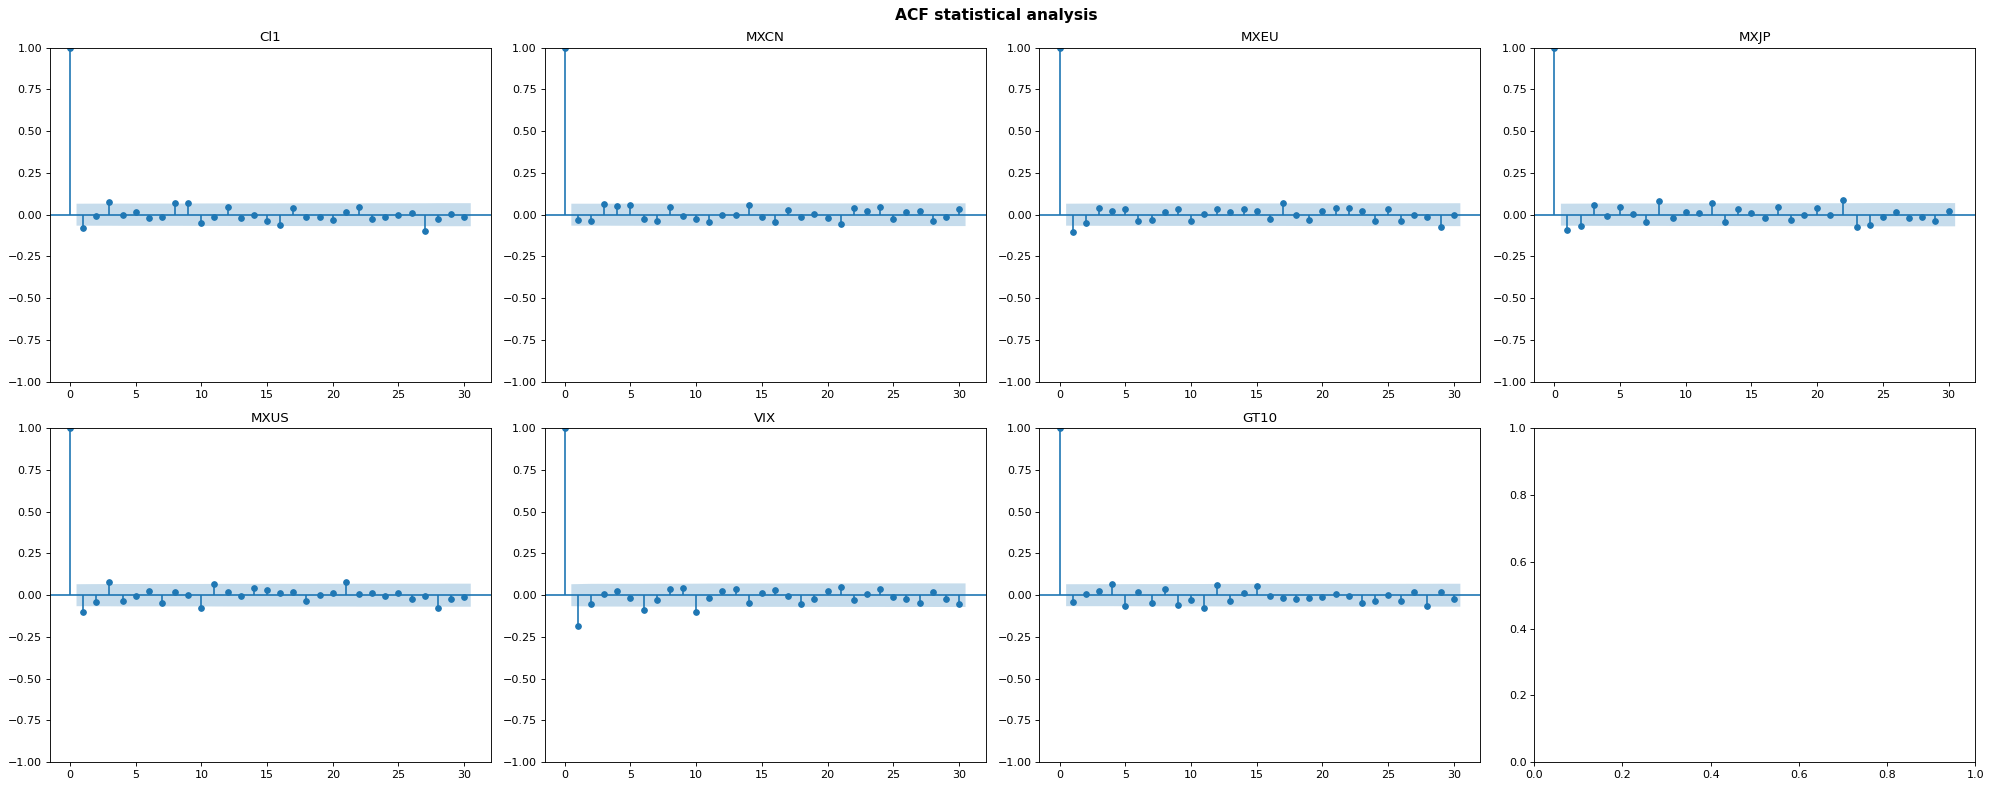

In [13]:
# ACF
row = 0
column = 0
cont=0
max_rows = 2
max_columns = 4
fig, axes = plt.subplots(max_rows, max_columns, figsize=(25, 10), dpi=80)
fig.suptitle('ACF statistical analysis', fontsize=14, fontweight='bold')


for i in range(len(train_df.columns)):
    cont=cont +1
    x = train_df[names[i]]
    ax = axes[row][column]

    tsaplots.plot_acf(x, lags=30, title=names[i], ax=ax)

    column = column + 1
    if column % max_columns == 0:
        column = 0
        row = row + 1

    if row >= max_rows or column >= max_columns:
        break

    if cont >6:
      break

plt.tight_layout()
plt.show()

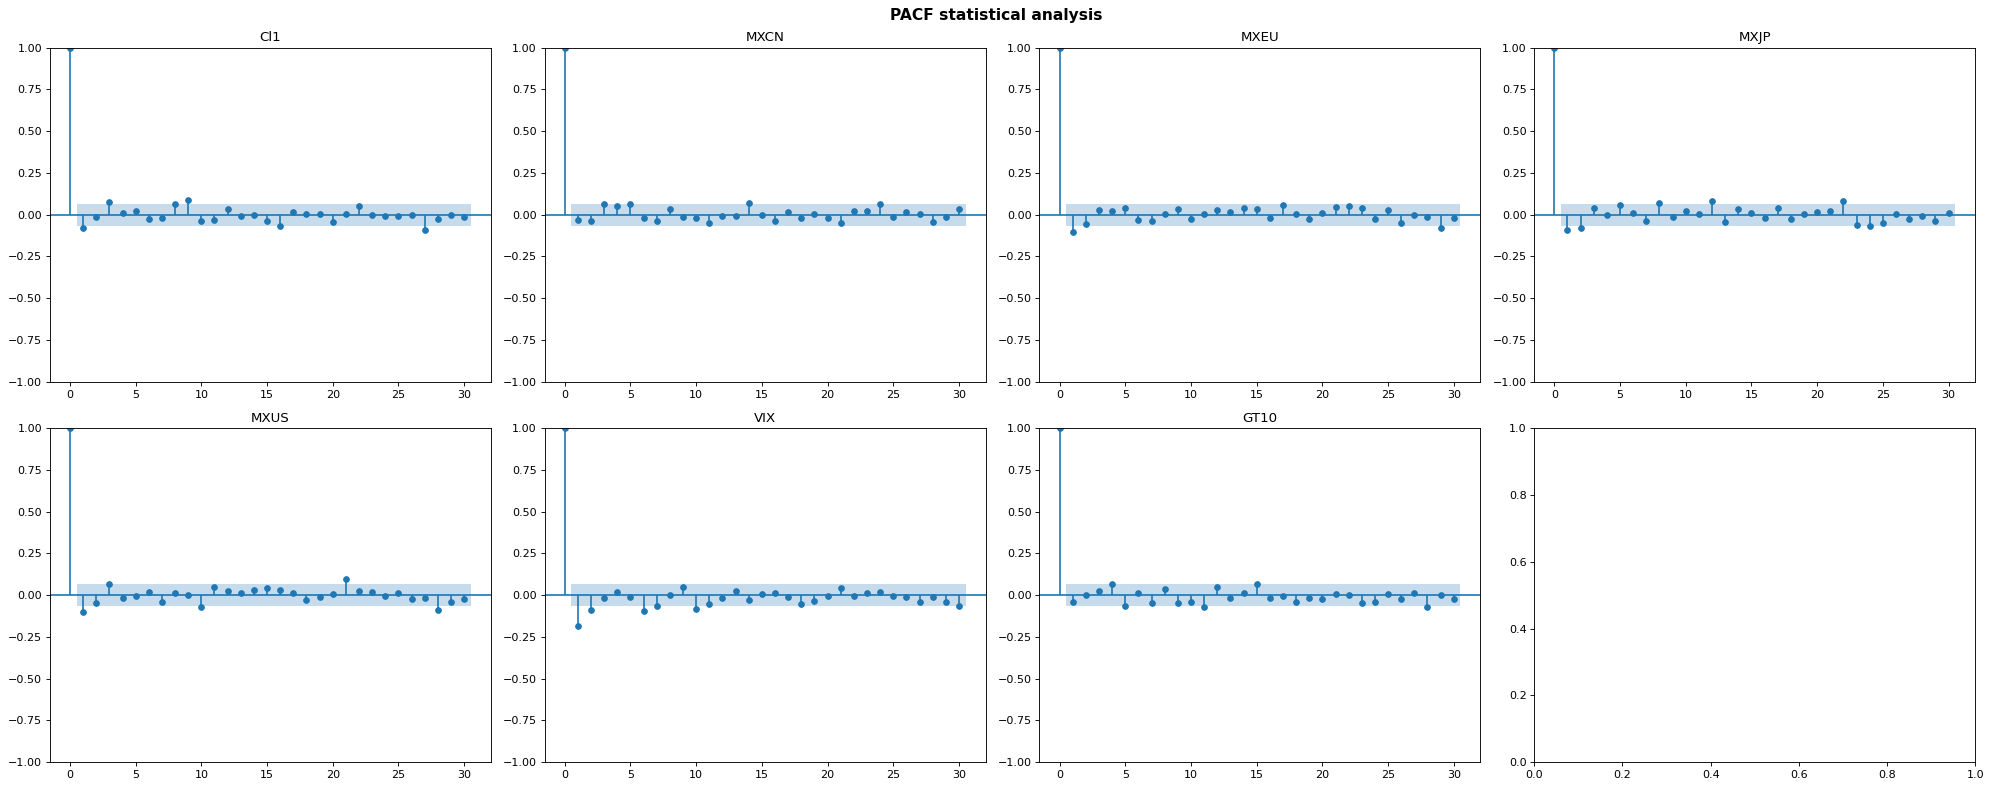

In [14]:
# PACF

row = 0
column = 0
cont=0
max_rows = 2
max_columns = 4
fig, axes = plt.subplots(max_rows, max_columns, figsize=(25, 10), dpi=80)
fig.suptitle('PACF statistical analysis', fontsize=14, fontweight='bold')


for i in range(len(train_df.columns)):
    cont=cont+1
    x = train_df[names[i]]
    ax = axes[row][column]

    tsaplots.plot_pacf(x, lags=30, title=names[i], ax=ax)

    column = column + 1
    if column % max_columns == 0:
        column = 0
        row = row + 1

    if row >= max_rows or column >= max_columns:
        break
    if cont >6:
      break

plt.tight_layout()
plt.show()

The stationarity of the return series was evaluated using the Augmented Dickey-Fuller (ADF) test. The results indicate that the null hypothesis of a unit root can be rejected at the 5% significance level, confirming that the return series is stationary.

The Autocorrelation Function (ACF) plot reveals that autocorrelation values fall within the 95% confidence intervals after the first lag. This suggests that there is no significant autocorrelation in the return series beyond the initial lag.

The Partial Autocorrelation Function (PACF) plot further supports the absence of autoregressive behavior. While a few lags may appear statistically significant, they lack meaningful financial interpretation. Therefore, when combining insights from both the ACF and PACF plots, we conclude that the return series does not exhibit ARMA-type structure in its mean dynamics.

# 2) Anomaly Detection

The following methods were evaluated:

**Long Short-Term Memory (LSTM)**:
LSTM is a type of recurrent neural network (RNN) specifically designed to capture long-term dependencies in sequential data. It is well-suited for time series analysis due to its ability to retain information over extended periods. In the context of anomaly detection, LSTM is applied as a binary classification model, distinguishing between normal and anomalous patterns in the data (further implementation details are provided in the dedicated LSTM section).

**Autoencoder**:
Autoencoders are unsupervised neural networks composed of two main components: an encoder that compresses the input into a latent representation, and a decoder that reconstructs the original input from this representation. For anomaly detection, the autoencoder is trained exclusively on "normal" data. During inference, reconstruction error serves as an anomaly score—higher errors indicate a divergence from normal patterns, signaling potential anomalies.

**Copula-Based Modeling**:
Copulas are statistical tools that model the dependence structure between random variables independently of their marginal distributions. For anomaly detection, copulas are employed to learn the typical dependency relationships among variables. Observations that exhibit significant deviations from these learned dependency structures are flagged as anomalies.


### LSTM

In [15]:
# This is the dimension of the window, which determines how much the network is able to look backward
# (in terms of number of time steps) in order to correctly classify the last time step of the series.
WINDOW = 52

# Function which prepares data in order to feed it to the LSTM network. Data is divided into windows
# (which are 'WINDOW' timestamps long) and reshaped into a ('samples', 'WINDOW', 'features') dimensional tensor.
def build_LSTM_samples(x, y, W=50):

  # INPUT:
  # x    : numpy array of training/validation samples (e.g. x_train.to_numpy())
  # y    : numpy array of training/validation labels (e.g. y_train.to_numpy())

  # OUPUT:
  # x_new: numpy array of training/validation samples split into windows
  # y_new: numpy array of training/validation labels (each label is associated to a window)

  samples = x.shape[0]
  features = x.shape[1]

  # defining the shape of the output data tensor
  x_new = np.empty((samples-W+1, W, features))

  # inserting the windows into the new data vector through looping and indexing
  for i in range(x_new.shape[0]):
    x_new[i] = x[i:i+W]

  # reshaping also the labels (the first W-1 labels are discarded)
  y_new = y[W-1:].reshape(y[W-1:].shape[0])

  return x_new, y_new


"""
# Function to calculate recall
def recall(y_true, y_pred):

  # INPUT:
  # y_true: numpy array of true labels
  # y_pred: numpy array of predicted labels

  # OUPUT:
  # recall: recall metric related to y_true and y_pred

  true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
  possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

"""

from tensorflow.keras.metrics import Recall

from tensorflow.keras import backend as K

class Recall(tf.keras.metrics.Metric):
    def __init__(self, name='recall', **kwargs):
        super(Recall, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.possible_positives = self.add_weight(name='pp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(K.clip(y_pred, 0, 1))
        y_true = K.cast(K.round(K.clip(y_true, 0, 1)), tf.float32)  # Cast to float32

        tp = K.sum(y_true * y_pred)
        pp = K.sum(y_true)

        self.true_positives.assign_add(tp)
        self.possible_positives.assign_add(pp)

    def result(self):
        return self.true_positives / (self.possible_positives + K.epsilon())

    def reset_states(self):
        self.true_positives.assign(0)
        self.possible_positives.assign(0)

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = K.round(K.clip(y_pred, 0, 1))
        y_true = K.cast(K.round(K.clip(y_true, 0, 1)), tf.float32)  # Cast to float32

        tp = K.sum(y_true * y_pred)
        fp = K.sum((1 - y_true) * y_pred)
        fn = K.sum(y_true * (1 - y_pred))

        self.true_positives.assign_add(tp)
        self.false_positives.assign_add(fp)
        self.false_negatives.assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + K.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + K.epsilon())
        return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

    def reset_states(self):
        self.true_positives.assign(0)
        self.false_positives.assign(0)
        self.false_negatives.assign(0)

In [16]:
# Creating training instances using build_samples function
x_train_window, y_train_window = build_LSTM_samples(x_train.to_numpy(), y_train.to_numpy(), WINDOW)

# Creating validation instances using build_samples function
x_val_window, y_val_window = build_LSTM_samples(np.append(x_train[1-WINDOW:], x_val, axis=0),
                                                np.append(y_train[1-WINDOW:], y_val, axis=0),
                                                WINDOW)

In [17]:
from tensorflow.keras.optimizers import Adam

def build_LSTM(input_shape):

    # INPUTS:
    # input_shape: shape of the input samples

    # OUTPUTS:
    # model      : LSTM keras model with specified architecture


    # Defining the input layer with the given input shape
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Defining the first LSTM layer with 8 units, relu activation, and return sequences (providing one output for each time step of the window)
    LSTM1 = tfkl.LSTM(units=8, activation='relu', return_sequences=True, name='LSTM1')(input_layer)

    # Defining the second LSTM layer with 4 units, relu activation, and no return sequences (providing a single output for the whole window)
    LSTM2 = tfkl.LSTM(units=4, activation='relu', return_sequences=False, name='LSTM2')(LSTM1)

    # Defining the dense layer with 32 units and relu activation
    dense = tfkl.Dense(units=32, activation='relu', name='classifier')(LSTM2)

    # Defining the output layer with 1 unit and sigmoid activation (the output is the probability that the last time step is an anomaly)
    output_layer = tfkl.Dense(units=1, activation='sigmoid', name='output')(dense)

    # Defining the model specifying input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compiling the model with binary cross-entropy loss (since it is a binary classification problem),
    # Adam optimizer, and custom metrics (recall and f1score) defined previously
    model.compile(
        loss=tfk.losses.BinaryCrossentropy(),
        optimizer=Adam(),
        metrics=[Recall(), F1Score()]
    )

    return model


In [18]:
# Defining the shape of the samples
input_shape = x_train_window.shape[1:]

# Building LSTM model and printing the architecture
LSTM_model = build_LSTM(input_shape)
LSTM_model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 52, 9)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM1 (LSTM)                    │ (None, 52, 8)          │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM2 (LSTM)                    │ (None, 4)              │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (Dense)              │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 977 (3.82 KB)

 Trainable params: 977 (3.82 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
epochs = 100
batch_size = 32

# Defining the EarlyStopping callback (monitoring the f1score) to prevent overfitting and to restore the best weights
callbacks = [tfk.callbacks.EarlyStopping(monitor='f1score', mode='max', patience=10, restore_best_weights=True)]

# Shuffling training and validation data
x_train_window, y_train_window = shuffle(x_train_window, y_train_window, random_state = seed)
x_val_window, y_val_window = shuffle(x_val_window, y_val_window, random_state = seed)

# Training LSTM model
history = LSTM_model.fit(
    x = x_train_window,
    y = y_train_window,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_val_window, y_val_window),
    callbacks = callbacks,
    class_weight = {0:1, 1:5} # Defining class weights to specify that anomaly samples are more important with respect to normal ones because of class imbalance
).history

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - f1score: 0.3718 - loss: 1.3518 - recall: 25.6545 - val_f1score: 0.2297 - val_loss: 0.7128 - val_recall: 28.4138
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - f1score: 0.3869 - loss: 1.3077 - recall: 30.6176 - val_f1score: 0.2303 - val_loss: 0.7428 - val_recall: 28.6207
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - f1score: 0.3858 - loss: 1.1630 - recall: 28.7024 - val_f1score: 0.2216 - val_loss: 1.0935 - val_recall: 22.6552
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - f1score: 0.3657 - loss: 1.0014 - recall: 21.4094 - val_f1score: 0.2043 - val_loss: 0.6350 - val_recall: 14.0690
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - f1score: 0.3244 - loss: 0.8792 - recall: 14.2556 - val_f1score: 0.1760 - val_loss: 0.5311 - val_recall: 8.7586
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - f1score: 0.3030 - loss: 0.8057 - recall: 11.6716 - val_f1score: 0.1750 - val_loss: 0.4690 - val_recall: 7.8621
Epoch 

In [20]:
# Predicting the probabilities for the validation data using the LSTM model
y_val_pred = LSTM_model.predict(x_val_window)


# Storing the predictions for later use
y_val_pred_best=np.copy(y_val_pred)

# Defining the start, stop, and step values for the threshold range
start = 0.2
stop = 0.8
step = 0.05

# Initializing the f1 score and best_threshold variables
f1 = 0
best_threshold = 0.5

# Creating a temporary copy of y_val_pred
y_val_temp = np.copy(y_val_pred)

# Iterating over the threshold values and find the best threshold based on the f1 score
for threshold in np.arange(start, stop+step, step):

    # Updating y_val_temp based on the current threshold
    y_val_temp[y_val_pred>=threshold]=1
    y_val_temp[y_val_pred<threshold]=0

    # Computing the f1 score using y_val_temp and compare it with the current best f1 score
    if f1_score(y_val_window, y_val_temp)>f1:
        f1 = f1_score(y_val_window, y_val_temp)
        best_threshold = threshold

# Printing the best threshold
print(f'Best threshold: {best_threshold:.2f}')

# Updating y_val_pred_best based on the best threshold
y_val_pred_best[y_val_pred>=best_threshold]=1
y_val_pred_best[y_val_pred<best_threshold]=0

# Computing the f1 score using y_val_window and y_val_pred_best
f1_score_LSTM = f1_score(y_val_window, y_val_pred_best)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
Best threshold: 0.60


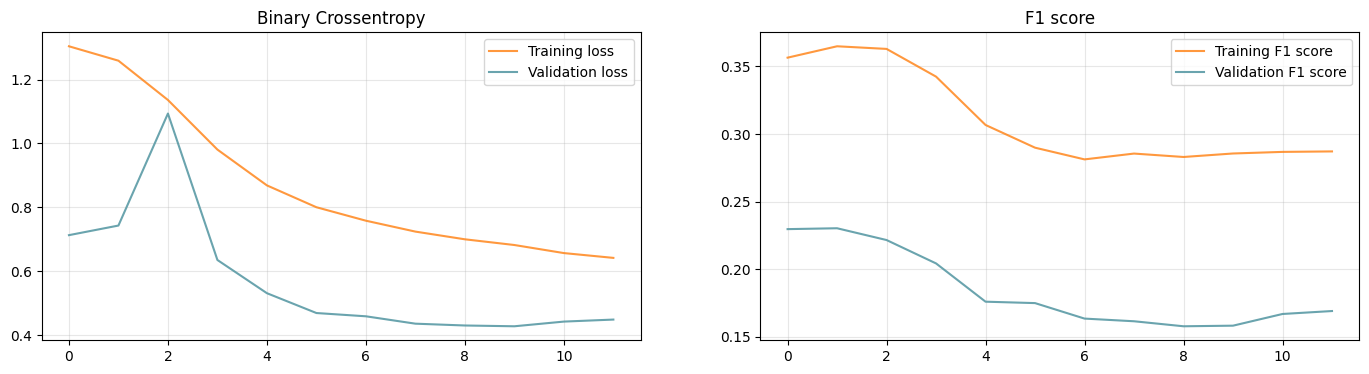

In [21]:
# Geting the epoch index with the highest validation recall
best_epoch = np.argmax(history['val_recall'])
fig, axes = plt.subplots(1, 2, figsize=(17,4))

axes[0].plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
axes[0].plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
axes[0].set_title('Binary Crossentropy')
axes[0].legend()
axes[0].grid(alpha=.3)

axes[1].plot(history['f1score'], label='Training F1 score', alpha=.8, color='#ff7f0e')
axes[1].plot(history['val_f1score'], label='Validation F1 score', alpha=.9, color='#5a9aa5')
axes[1].set_title('F1 score')
axes[1].legend()
axes[1].grid(alpha=.3)

In [22]:
cf_matrix = (confusion_matrix(y_val_window, y_val_pred_best, labels=[0, 1], sample_weight=None) / len(y_val_window) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(f'Accuracy:\t{accuracy_score(y_val_window,y_val_pred_best):.3f}')
print(f'Recall:\t\t{recall_score(y_val_window, y_val_pred_best):.3f}')
print(f'Precision:\t{precision_score(y_val_window, y_val_pred_best):.3f}')
print(f'F1score:\t{f1_score(y_val_window, y_val_pred_best):.3f}')

# Print the confusion matrix values and percentages
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.869
Recall:		0.379
Precision:	0.500
F1score:	0.431
True Neg:	81.98%
False Pos:	4.95%
False Neg:	8.11%
True Pos:	4.95%


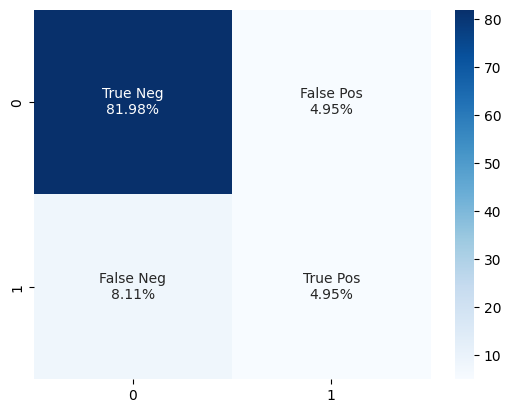

In [23]:
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Autoencoder

In [24]:
# This function creates training widows of dimension W made only of normal data
def build_Autoencoder_samples(x, y, W=52):

    # INPUT:
    # x    : numpy array of training samples (e.g. x_train.to_numpy())
    # y    : numpy array of training labels (e.g. y_train.to_numpy())
    # W    : window dimension of the new training samples (default is 52, it should
    #        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # x_new: numpy array of new training samples split into windows

    x_norm = x[y==0]

    samples = x_norm.shape[0]
    features = x_norm.shape[1]

    indexes = np.arange(0, samples-W+1, 1)

    # defining the shape of the output data tensor
    x_new = np.empty((len(indexes), W, features))

    # inserting the windows into the new data vector through looping and indexing

    for i, j in enumerate(indexes):
        x_new[i] = x_norm[j:j+W]

    return x_new


# This function creates validation widows of dimension W made of normal and validation data
# The only difference with respect to previous function is that with this function the anomalies are not removed
def build_Autoencoder_test_samples(x, W=52):

    # INPUT:
    # x    : numpy array of training samples (e.g. x_train.to_numpy())
    # W    : window dimension of the new training samples (default is 52, it should
    #        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # x_new: numpy array of new training samples split into windows

    x_copy = np.copy(x)

    samples = x_copy.shape[0]
    features = x_copy.shape[1]

    indexes = np.arange(0, samples-W+1, 1)

    # defining the shape of the output data tensor
    x_new = np.empty((len(indexes), W, features))

    # inserting the windows into the new data vector through looping and indexing

    for i, j in enumerate(indexes):
        x_new[i] = x_copy[j:j+W]

    return x_new


# This function calculates the average reconstruction errors related to each validation time step
def build_true_errors(reconstruction_errors, W=52):

    # reconstruction_errors: numpy array of reconstruction errors related to validation samples (the output of the network)
    # W                    : window dimension of the new training samples (default is 52, it should
    #                        be divisible by 4 because of convolutional autoencoder architecture)

    # OUPUT:
    # true_errors          : numpy array with length equal to the number of validation time steps
    #                        containing the average reconstruction error for each time step

    # Reshape the reconstruction errors to match the desired shape
    reshaped_errors = reconstruction_errors.reshape((reconstruction_errors.shape[0], reconstruction_errors.shape[1]))
    # Initialize arrays for storing true errors and counts
    true_errors = np.zeros(reconstruction_errors.shape[0]+W-1)
    counts = np.copy(true_errors)

    for i in range(reconstruction_errors.shape[0]):
        # Accumulate reconstruction errors over a sliding window of size W
        true_errors[i:i+W] += reshaped_errors[i]
        # Keep track of the number of errors accumulated in each window
        counts[i:i+W] += 1
    # Calculate the average errors within each window
    true_errors = true_errors / counts
    return true_errors


# This function computes the value of the reconstruction error threshold which maximizes the F1 score on the validation set
def find_threshold(errors, labels, upper=4, lower=0, eps=0.01):

    # INPUT:
    # errors   : numpy array containing the average reconstruction error
    #            for each time step (output of build_true_errors function)
    # labels   : array containing the labels associated to each time step
    # upper    : upper limit for the threshold value
    # lower    : lower limit for the threshold value
    # eps      : value of the threshold increment

    # OUPUT:
    # threshold: value of the threshold that maximizes the f1 score on the validation set
    # f1       : value of the maximum achieved f1 score

    f1 = 0
    threshold = lower
    temp_labels = np.empty(labels.shape)

    for i in np.arange(lower, upper, eps):
        # Assign labels based on the error threshold
        temp_labels[errors>=i] = 1
        temp_labels[errors<i] = 0
        # Update the best threshold and F1 score if the current F1 score is higher
        if (f1_score(labels, temp_labels)>f1):
            f1 = f1_score(labels, temp_labels)
            threshold = i

    return threshold, f1


# This function transforms the reconstruction errors array into an array of probabilities by applying the sigmoid function
def build_probabilities(errors, threshold):

    # INPUT:
    # errors       : numpy array containing the average reconstruction error
    #                for each time step (output of build_true_errors function)
    # threshold    : value of the threshold that maximizes the f1 score on the validation set

    # OUPUT:
    # probabilities: probability numpy array obtained by applying the sigmoid function to errors array

    # Define the base of the natural logarithm (e)
    e = 2.71828
    # Define the scaling factor to control the sigmoid function
    scaling_factor = -3
    # Transform the errors using the sigmoid function
    # The sigmoid function maps the errors to the range [0, 1]
    # The scaling factor adjusts the steepness of the sigmoid curve
    # A higher scaling factor makes the curve steeper, leading to sharper probabilities
    # A lower scaling factor makes the curve flatter, resulting in smoother probabilities
    probabilities = 1 / (1 + np.power(e, scaling_factor*(errors - threshold)))

    return probabilities

In [25]:
x_train_auto = build_Autoencoder_samples(x_train, y_train)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_train_auto = x_train_auto.reshape(x_train_auto.shape + (1, ))

x_val_auto = build_Autoencoder_samples(x_val, y_val)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_val_auto = x_val_auto.reshape(x_val_auto.shape + (1, ))

x_test_auto = build_Autoencoder_test_samples(x_val)
# reshaping the data in order to be able to use 2D convolutional layers during training
x_test_auto = x_test_auto.reshape(x_test_auto.shape + (1, ))

In [26]:
def build_Conv_Autoencoder(input_shape):

    # INPUTS:
    # input_shape: shape of the input samples

    # OUTPUTS:
    # model      : Autoencoder keras model with specified architecture

    input_layer = tfkl.Input(shape=input_shape, name='Input')

    # Defining the number of filters and the filter size for each layer
    FILTERS_1 = 3
    FILTERS_2 = 5
    FILTERS_3 = 15
    KERNEL_SIZE_1 = (15, 1)
    KERNEL_SIZE_2 = (8, 1)
    KERNEL_SIZE_3 = (3, 1)
    POOL_SIZE = (2, 1)

    # encoder part of the autoencoder consisting in two (convolutional + max pooling) modules
    encoder_conv_1 = tfkl.Conv2D(filters=FILTERS_1, kernel_size=KERNEL_SIZE_1, padding='same', activation='relu', name='EncoderConv1')(input_layer)
    encoder_mp_1 = tfkl.MaxPooling2D(pool_size=POOL_SIZE, name='EncoderMP1')(encoder_conv_1)
    encoder_conv_2 = tfkl.Conv2D(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, padding='same', activation='relu', name='EncoderConv2')(encoder_mp_1)
    encoder_mp_2 = tfkl.MaxPooling2D(pool_size=POOL_SIZE, name='EncoderMP2')(encoder_conv_2)

    # reduced representation layer of the autoencoder
    middle_conv = tfkl.Conv2D(filters=FILTERS_3, kernel_size=KERNEL_SIZE_3, padding='same', activation='relu', name='MiddleConv2')(encoder_mp_2)

    # decoder part of the autoencoder consisting in two unpooling layers with a batch normalization layer in between
    decoder_conv_2 = tfkl.Conv2DTranspose(filters=FILTERS_2, kernel_size=KERNEL_SIZE_2, strides=POOL_SIZE, padding='same', activation='relu', name='DecoderConv2')(middle_conv)
    decoder_bn_2 = tfkl.BatchNormalization(name='BatchNorm2')(decoder_conv_2)
    output_layer = tfkl.Conv2DTranspose(filters=1, kernel_size=KERNEL_SIZE_1, strides=POOL_SIZE, padding='same', activation='relu', name='Output')(decoder_bn_2)

    # Defining the model specifying input and output layers
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compiling the model with mean squared error loss (since it is a sort of regression problem) and Adam optimizer
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=Adam())

    return model

In [27]:
# Defining the shape of the samples
input_shape = x_train_auto.shape[1:]

# Building Autoencoder model and printing the architecture
Autoencoder_model = build_Conv_Autoencoder(input_shape)
Autoencoder_model.summary(line_length = 100)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                               ┃ Output Shape                    ┃           Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)                         │ (None, 52, 9, 1)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ EncoderConv1 (Conv2D)                      │ (None, 52, 9, 3)                │                48 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ EncoderMP1 (MaxPooling2D)                  │ (None, 26, 9, 3)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ EncoderConv2 (Conv2D)                      │ (None, 26, 9, 5)                │               125 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ EncoderMP2 (MaxPooling2D)                  │ (None, 13, 9, 5)                │                 0 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ MiddleConv2 (Conv2D)                       │ (None, 13, 9, 15)               │               240 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ DecoderConv2 (Conv2DTranspose)             │ (None, 26, 9, 5)                │               605 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ BatchNorm2 (BatchNormalization)            │ (None, 26, 9, 5)                │                20 │
├────────────────────────────────────────────┼─────────────────────────────────┼───────────────────┤
│ Output (Conv2DTranspose)                   │ (None, 52, 9, 1)                │                76 │
└────────────────────────────────────────────┴─────────────────────────────────┴───────────────────┘

 Total params: 1,114 (4.35 KB)

 Trainable params: 1,104 (4.31 KB)

 Non-trainable params: 10 (40.00 B)

In [28]:
epochs = 500
batch_size = 32

# Defining the EarlyStopping callback (monitoring the f1score) to prevent overfitting and to restore the best weights
callbacks = [tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True)]

# Shuffling training and validation data
x_train_auto = shuffle(x_train_auto, random_state = seed)
x_val_auto = shuffle(x_val_auto, random_state = seed)

history = Autoencoder_model.fit(
    x = x_train_auto,
    y = x_train_auto,
    epochs = epochs,
    batch_size = batch_size,
    validation_data = (x_val_auto, x_val_auto),
    callbacks = callbacks,
).history

Epoch 1/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.8807 - val_loss: 0.7101
Epoch 2/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.7316 - val_loss: 0.7064
Epoch 3/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.7051 - val_loss: 0.6995
Epoch 4/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6894 - val_loss: 0.6895
Epoch 5/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6769 - val_loss: 0.6803
Epoch 6/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6656 - val_loss: 0.6712
Epoch 7/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6544 - val_loss: 0.6622
Epoch 8/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.6407 - val_loss: 0.6513
Epoch 9/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6211 - val_loss: 0.6363
Epoch 10/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.5973 - val_loss: 0.6110
Epoch 11/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.5759 - val_loss: 0.5869
Epoch 12/500
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

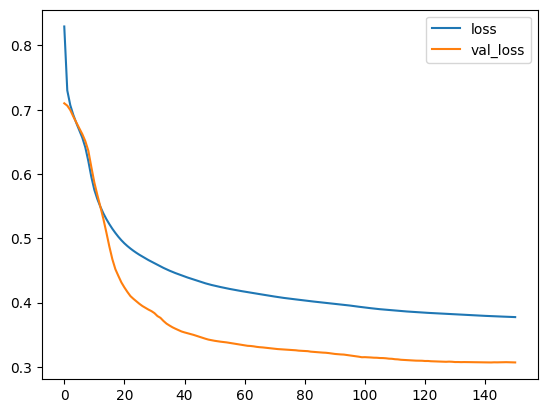

In [29]:
plotLine = ['loss', 'val_loss']
plt.plot(history[plotLine[0]][0:])
plt.plot(history[plotLine[1]][0:])
plt.legend(plotLine)
plt.show()

- Defining the reconstruction error of a time step as a mean squared error: they are computed as the mean of the squared difference between the true values of the features of a time step and the predicted values;
- Using <code>build_true_errors</code> to get a vector containing the average reconstruction error for each sample;
- Using <code>find_threshold</code> on the reconstruction errors just computed to find the optimal threshold and F1 scores;
- Using <code>build_probabilities</code> to compute the probability for each time step to be classified as an anomaly starting from the reconstruction errors vector and the optimal threshold.

In [30]:
reconstruction_errors = np.mean(np.power(x_test_auto - Autoencoder_model.predict(x_test_auto), 2), axis=2)
true_errors = build_true_errors(reconstruction_errors)

best_threshold_Autoencoder, f1_score_Autoencoder = find_threshold(true_errors, y_val)
res_autoencoder = build_probabilities(true_errors, best_threshold_Autoencoder)

print(f"Best threshold: {best_threshold_Autoencoder}")
print(f"Best F1: {f1_score_Autoencoder}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Best threshold: 0.74
Best F1: 0.5555555555555556


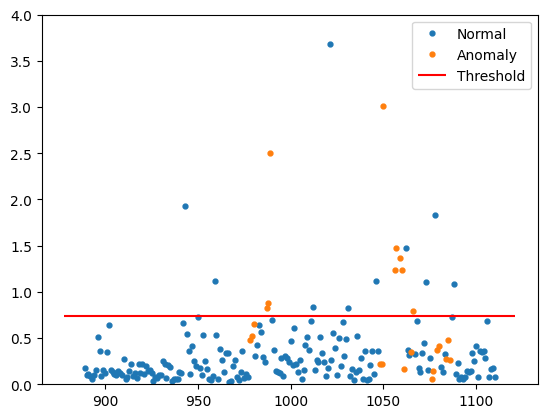

In [31]:
errors_df = pd.DataFrame({'Y_test': y_val,'Score': true_errors})
groups = errors_df.groupby('Y_test')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Score, marker='o', ms=3.5, linestyle='', label= "Anomaly" if name == 1 else "Normal")

ax.hlines(best_threshold_Autoencoder, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.set_ylim((0, 4))
ax.legend()

plt.show()

In [32]:
y_val_pred_auto = np.empty(res_autoencoder.shape)
y_val_pred_auto[res_autoencoder>=0.5] = 1
y_val_pred_auto[res_autoencoder<0.5] = 0
cf_matrix = (confusion_matrix(y_val, y_val_pred_auto, labels=[0, 1], sample_weight=None) / len(y_val_window) * 100)

group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v3}' for v1, v3 in zip(group_names, group_percentages)]
labels = np.asarray(labels).reshape(2,2)

print(f'Accuracy:\t{accuracy_score(y_val,y_val_pred_auto):.3f}')
print(f'Recall:\t\t{recall_score(y_val, y_val_pred_auto):.3f}')
print(f'Precision:\t{precision_score(y_val, y_val_pred_auto):.3f}')
print(f'F1score:\t{f1_score(y_val, y_val_pred_auto):.3f}')

# Print the confusion matrix values and percentages
for var, val in zip(group_names, group_percentages):
  print(f'{var}:\t{val}')

Accuracy:	0.892
Recall:		0.517
Precision:	0.600
F1score:	0.556
True Neg:	82.43%
False Pos:	4.50%
False Neg:	6.31%
True Pos:	6.76%


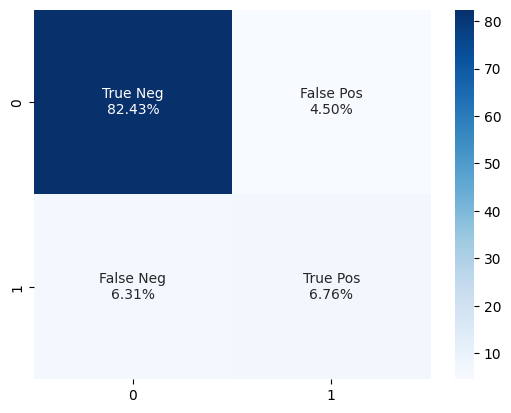

In [33]:
_ = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

### Copula

In [34]:
# separating input data from labels
x_train_copula = train_df.drop(labels = 'Y', axis = 1).to_numpy()
x_val_copula = val_df.drop(labels = 'Y', axis = 1).to_numpy()
y_train_copula = train_df['Y'].to_numpy()
y_val_copula = val_df['Y'].to_numpy()

In [35]:
# Delete anomalies from training sets
X_train = np.delete(x_train_copula, np.where(y_train == 1)[0], axis=0)
y_train = np.delete(y_train_copula, np.where(y_train == 1)[0], axis=0)


In [36]:
# Get standard normally distributed data
std_scaler = StandardScaler()
std_scaler.fit(X_train)
X_train = std_scaler.transform(X_train)
X_val = std_scaler.transform(x_val_copula)

In [37]:
# COPULA fit
clf = COPOD()
clf.fit(X_train)

y_train_scores = clf.decision_function(X_train)                                  # scores

# Get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_                                                       # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_                                            # raw outlier scores

# Get the prediction on the test data
cop_pred = clf.predict(X_val)                                                    # outlier labels (0 or 1)
cop_scores = clf.decision_function(X_val)                                        # outlier scores


In [38]:
# This function computes the following metrics: precision, recall anf f1 score
def confusion_metrics(y_test_pred, y_test):

    # INPUTS:
    # y_test_pred  : model prediction results comming from a test set [here, it is array of 0,1]
    # y_test       : real data of the test test

    # OUTPUTS:
    # precision, recall and f1 score

    tp = np.sum((y_test_pred == 1) & (y_test == 1))                               # true positive
    fp = np.sum((y_test_pred == 1) & (y_test == 0))                               # false positive
    fn = np.sum((y_test_pred == 0) & (y_test == 1))                               # false negative
    precision = tp / (tp + fp)                                                    # precision
    recall = tp / (tp + fn)                                                       # recall
    F1 = 2 * precision * recall / (precision + recall)                            # F1 score

    return precision,recall,F1

In [39]:
# The following function returns f1 score of a method
def compute_F1(y_test_pred, y_test):

    # INPUTS:
    # y_test_pred  : model prediction results comming from a test set [here, it is array of 0,1]
    # y_test       : real data of the test test

    # OUTPUTS:
    # f1 score

    precision, recall, F1 = confusion_metrics(y_test_pred, y_test)

    return F1

In [40]:
threshold = np.arange(min(cop_scores), max(cop_scores), 0.01)                    # range of discretized threshold

best_F1 = 0                                                                      # synthetic value to enter the if clause (below)
error = 0.05                                                                     # allowed error

for thres in threshold:
    for i in range(0,len(y_val)):
        cop_pred[i] = cop_scores[i]> thres                                        # update test prediction values [values must be 0 or 1]

    F1 = compute_F1(cop_pred, y_val)                                              # updated f1 score

    if F1 > best_F1:
      best_F1 = F1                                                               # the highest value of f1 score
      predictions = cop_pred
      threshold_calibrated = thres                                               # optimal threshold [it maximizes the f1 score]

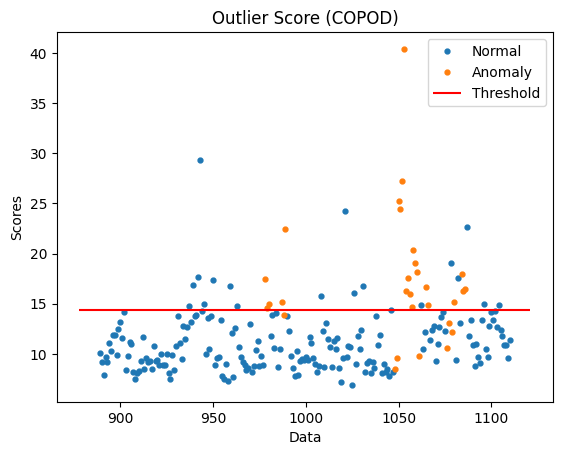

In [41]:
# Visualization tool

conf_results = pd.DataFrame({'Y_pred': cop_pred,'Y_test': y_val,'Score': cop_scores})
groups = conf_results.groupby('Y_test')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Score, marker='o', ms=3.5, linestyle='', label= "Anomaly" if name == 1 else "Normal")

ax.hlines(threshold_calibrated, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Outlier Score (COPOD)")
plt.ylabel("Scores")
plt.xlabel("Data")
plt.show();

In [42]:
# metrics considering the optimal threshold [the biggest f1 score]

for i in range(0,len(y_val)):
  cop_pred[i] = cop_scores[i]> threshold_calibrated

precision, recall, F1 = confusion_metrics(cop_pred, y_val)
print("Precision: ", precision)
print("Recall: ",recall)
print("F1 Score: ",F1)

best_threshold_Copula = threshold_calibrated
f1_score_Copula = F1

Precision:  0.55
Recall:  0.7586206896551724
F1 Score:  0.6376811594202898


# 3) Models Ensamble

The ensamble of models predicts a probability as the average of the probabilities predicted by each model, weighted by the goodness of each model (in terms of F1 score).

New test data was downloaded from Bloomberg (2021-2023 period), but for this period labels were not available. To test the goodness of the final model, the predicted labels of the ensamble average are used to control the behavior (in terms of investment risk propensity) of a synthetic portfolio.

In [43]:
import time

# This function downloads and returns market data from yfinance
def get_market_prices(start_date, end_date, asset_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download [it must be a string: ex. '^GSPC']

  # OUTPUT:
  # prices      : array with prices of asset_name at market's closure time


    market_data = yf.download(asset_name, start=start_date, end=end_date, interval='1wk') # download
    time.sleep(1)
    prices = market_data['Close'].to_numpy()                                              # array with the closure prices

    return prices



# This function converts data downloaded from yfinance in USD
def USD_conversion(start_date, end_date, asset_values, forex_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_values: prices in the original currency
  # forex_name  : name of the currency-conversione to download. IT MUST be USD vs other currency (and NOT viceversa) [it must be a string]

  # OUTPUT:
  # prices      : array with USD prices of asset_name at market closure time

  conversion_rates = get_market_prices(start_date, end_date, forex_name)          # get currency converison rate
  conversion_rates = np.asarray(conversion_rates).flatten()
  prices = asset_values / conversion_rates                                        # asset price in USD

  return prices

In [44]:
# defining the start and end dates of the data we want to download
start_date = '2021-04-23'
end_date = '2023-05-12'

# reading dataframe from excel file
df_test = pd.read_excel('TestSet.xlsx')

df_test['Data'] = pd.to_datetime(df['Data'], format='%d-%m-%Y')

print(df_test.head())


# adding missing data
gold_test =  get_market_prices(start_date,end_date,'GC=F')
df_test['XAUBGNL'] = gold_test

# converting to US dollars
df_test['MXCN'] = USD_conversion(start_date, end_date, df_test['MXCN'], 'HKD=X')
df_test['MXEU'] = USD_conversion(start_date, end_date, df_test['MXEU'], 'EUR=X')
df_test['MXJP'] = USD_conversion(start_date, end_date, df_test['MXJP'], 'JPY=X')

# adding sp_gold column to dataframe
df_test = add_sp_gold(df_test)
df_test.drop(labels = 'XAUBGNL', axis = 1, inplace = True)

returns_labels = ['Cl1', 'MXCN', 'MXEU', 'MXJP', 'MXUS', 'VIX', 'GT10']
returns_features = df_test[returns_labels].to_numpy()

# calculating the returns as the differences between feature at time t and time t-1, divided by feature at time t-1 (times 100)
returns_test = pd.DataFrame(np.diff(returns_features, axis=0) / returns_features[:-1, :]) * 100

# restoring the original column names and indexes
returns_test.columns = returns_labels
returns_test.index = df_test.index[1:]

df_test = pd.concat([returns_test, df_test[['SP_GOLD', 'ECSURPUS']].iloc[1:]], axis=1)

# building the final test set by applying same scaling of the training set
dummy, x_test = scaler(train_df, df_test)

        Data    MXCN     MXJP    MXEU     MXUS    Cl1    VIX   GT10  ECSURPUS
0 2000-01-11  111.59  1172.28  145.32  4064.42  62.14  17.33  1.560     0.526
1 2000-01-18  109.72  1161.88  144.69  4061.26  63.58  18.61  1.628     0.560
2 2000-01-25  107.28  1181.25  147.24  4094.35  64.90  16.69  1.579     0.393
3 2000-02-01  103.89  1151.05  146.58  4035.52  65.37  18.81  1.630     0.349
4 2000-02-08  106.44  1164.95  147.19  4024.55  63.58  20.15  1.622     0.245


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Standard scaling was applied


In [45]:
df_test

,Cl1,MXCN,MXEU,MXJP,MXUS,VIX,GT10,SP_GOLD,ECSURPUS
1,2.317348,-1.773765,-1.066420,-2.086013,-0.077748,7.386036,4.358974,0.815572,0.560
2,2.076125,-2.207469,2.975461,2.267370,0.814772,-10.317034,-3.009828,0.742810,0.393
3,0.724191,-3.182773,-0.593106,-3.251682,-1.436858,12.702217,3.229892,0.774999,0.349
4,-2.738259,2.501104,0.708875,1.635138,-0.271836,7.123870,-0.490798,0.739127,0.245
5,4.309531,2.157102,1.004017,1.646429,1.252314,-16.823821,-1.602959,0.707537,0.237
...,...,...,...,...,...,...,...,...,...
103,2.255266,-0.315369,2.678514,1.498459,0.829473,-7.228261,3.564065,0.585611,-0.087
104,-5.634998,-2.436983,0.441296,0.493927,-0.119450,-1.757469,1.649602,0.578732,-0.028
105,-1.399769,-1.438479,-0.266993,-0.542588,0.740505,-5.903399,-4.168998,0.566595,0.053
106,-7.085178,0.651403,0.481437,2.082744,-0.763917,8.935361,0.437956,0.561753,0.208


Building the test set probability vector for **LSTM**.

In [46]:
# LSTM
x_test_LSTM, _ = build_LSTM_samples(pd.concat([x_val.iloc[-49:], x_test], axis=0), np.empty(x_test.shape[1]))
y_test_LSTM = LSTM_model.predict(x_test_LSTM).reshape(-1)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 


Building the test set probability vector for **Autoencoder**.

In [47]:
# Autoencoder
x_test_Autoencoder = build_Autoencoder_test_samples(x_test)
x_test_Autoencoder = x_test_Autoencoder.reshape(x_test_Autoencoder.shape + (1, ))
test_errors = np.mean(np.power(x_test_Autoencoder - Autoencoder_model.predict(x_test_Autoencoder), 2), axis=2)
true_test_errors = build_true_errors(test_errors)
y_test_Autoencoder = build_probabilities(true_test_errors, best_threshold_Autoencoder)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Building the test set probability vector for **Copula**.

In [48]:
# Copula
x_test_copula = df_test.to_numpy()
x_test_copula = std_scaler.transform(x_test_copula)
cop_pred = clf.predict(x_test_copula)
cop_scores = clf.decision_function(x_test_copula)
e = 2.71828
y_test_copula = 1 / (1 + np.power(e, -2*(cop_scores - best_threshold_Copula)))

Computing the sum of the F1 scores achieved by each model.

In [49]:
sum_f1_scores = f1_score_LSTM + f1_score_Autoencoder + f1_score_Copula

Computing the probability assigned by the ensamble of models as the average of the probabilities predicted by each model, weighted by the goodness of each model (in terms of F1 score).

In [50]:
y_test = (
          y_test_LSTM * f1_score_LSTM +
          y_test_Autoencoder * f1_score_Autoencoder +
          y_test_copula * f1_score_Copula
          ) / sum_f1_scores

# 4) Synthetic Portfolio

In [51]:
# This function downloads from yahoo finance the prices of an asset for a given time window
def get_market_prices(start_date, end_date, asset_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download [it must be a string: ex. '^GSPC']

  # OUTPUT:
  # prices      : array with prices of asset_name at market's closure time


    market_data = yf.download(asset_name, start=start_date, end=end_date, interval='1wk') # download
    prices = market_data['Close'].to_numpy()                                              # array with the closure prices

    return prices

In [52]:
# This function converts in USD the prices of an asset traded on a different currency
def get_prices_USD(start_date, end_date, asset_name, forex_name):

  # INPUTS:
  # start_date  : first date of the timeframe
  # end_date    : last date of the timeframe
  # asset_name  : name of the asset to download. It is not traded in USD [it must be a string: ex. '^GSPC']
  # forex_name  : name of the currency-conversione to download. IT MUST be USD vs other currency (and NOT viceversa) [it must be a string]

  # OUTPUT:
  # prices      : array with USD prices of asset_name at market's closure time


  asset_prices_non_USD = get_market_prices(start_date, end_date, asset_name)     # assets download
  coversion_rates = get_market_prices(start_date, end_date, forex_name)          # forex

  prices = asset_prices_non_USD / coversion_rates                                # asset price in USD

  return prices


In [53]:
# This function retrives the risk label by means of specific thresholds passed as input parameters
def get_labels(thresh_up, thresh_down,y_test_scores):

  # INPUTS:
  # thresh_up         : upper threshold [it separates medium from high risk class]
  # thresh_down       : lower threshhold [it separates medium from low risk class]
  # y_test_scores     : model outputs to be converted into risk labels

  # OUTPUT:
  # market_risk_labels :  list with  a risk label for each time instant


  market_risk_labels=[]

  for p in y_test_scores:
    if p >= thresh_up:                                                           # high risk condition
        market_risk_labels.append('High')
    elif p >= thresh_down:                                                       # medium risk condition
        market_risk_labels.append('Medium')
    elif p < thresh_down:
        market_risk_labels.append('Low')                                         # low risk contition

  return market_risk_labels

In [54]:
# Date range
start_date = '2021-04-23'
end_date = '2023-05-12'

"""
# EQUITY
n_equity = 10
aapl = get_market_prices(start_date, end_date, 'AAPL')        # Apple
jpm = get_market_prices(start_date, end_date, 'JPM')          # JPMorgan
pg = get_market_prices(start_date, end_date, 'PG')            # Procter & Gamble
jnj = get_market_prices(start_date, end_date, 'JNJ')          # Johnson & Johnson
xom = get_market_prices(start_date, end_date, 'XOM')          # Exxon Mobil
cat = get_market_prices(start_date, end_date, 'CAT')          # Caterpillar
wmt = get_market_prices(start_date, end_date, 'WMT')          # Walmart
meta = get_market_prices(start_date, end_date, 'META')        # Meta Platforms
nvda = get_market_prices(start_date, end_date, 'NVDA')        # NVIDIA
dal = get_market_prices(start_date, end_date, 'DAL')          # Delta Air Lines

# BONDS
n_bonds = 5
tlt = get_market_prices(start_date, end_date, 'TLT')          # Long-term Treasury
agg = get_market_prices(start_date, end_date, 'AGG')          # Aggregate Bond
tip = get_market_prices(start_date, end_date, 'TIP')          # TIPS
lqd = get_market_prices(start_date, end_date, 'LQD')          # Investment Grade Corp
hyg = get_market_prices(start_date, end_date, 'HYG')          # High Yield Corp

# COMMODITIES
n_commodities = 5
gld = get_market_prices(start_date, end_date, 'GLD')          # Gold ETF
slv = get_market_prices(start_date, end_date, 'SLV')          # Silver ETF
uso = get_market_prices(start_date, end_date, 'USO')          # Oil ETF
ung = get_market_prices(start_date, end_date, 'UNG')          # Natural Gas ETF
dba = get_market_prices(start_date, end_date, 'DBA')          # Agriculture ETF

# Combine all into a portfolio list
ptf = [
    aapl, jpm, pg, jnj, xom, cat, wmt, meta, nvda, dal,
    tlt, agg, tip, lqd, hyg,
    gld, slv, uso, ung, dba
]
"""

# EQUITY
n_equity = 10
sp500 = get_market_prices(start_date, end_date, '^GSPC')             # S&P 500 Index
euro_stoxx = get_market_prices(start_date, end_date, 'FEZ')          # Euro Stoxx 50 ETF
ewj = get_market_prices(start_date, end_date, 'EWJ')                 # Japan ETF
ewh = get_market_prices(start_date, end_date, 'EWH')                 # Hong Kong ETF
ewa = get_market_prices(start_date, end_date, 'EWA')                 # Australia ETF
eem = get_market_prices(start_date, end_date, 'EEM')                 # Emerging Markets ETF
ewz = get_market_prices(start_date, end_date, 'EWZ')                 # Brazil ETF
xlk = get_market_prices(start_date, end_date, 'XLK')                 # US Tech Sector ETF
xlf = get_market_prices(start_date, end_date, 'XLF')                 # US Financial Sector ETF
spy = get_market_prices(start_date, end_date, 'SPY')                 # S&P 500 ETF

# BONDS
n_bonds = 5
vbtlx = get_market_prices(start_date, end_date, 'VBTLX')            # Total US Bond Market
ief = get_market_prices(start_date, end_date, 'IEF')                # 7-10 Year Treasury
tlt = get_market_prices(start_date, end_date, 'TLT')                # Long-Term Treasury
vety = get_prices_USD(start_date, end_date, 'VETY.L', 'GBP=X')      # European Gov Bonds (GBP -> USD)
emb = get_market_prices(start_date, end_date, 'EMB')                # Emerging Markets Bonds

# COMMODITIES
n_commodities = 5
spgsci = get_market_prices(start_date, end_date, '^SPGSCI')         # Broad commodity index
oil = get_market_prices(start_date, end_date, 'CL=F')               # Crude oil futures
gold = get_market_prices(start_date, end_date, 'GC=F')              # Gold futures
natgas = get_market_prices(start_date, end_date, 'NG=F')            # Natural gas futures
dba = get_market_prices(start_date, end_date, 'DBA')                # Agricultural commodities ETF

# Combine all into a portfolio list
ptf = [
    sp500, euro_stoxx, ewj, ewh, ewa, eem, ewz, xlk, xlf, spy,
    vbtlx, ief, tlt, vety, emb,
    spgsci, oil, gold, natgas, dba
]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

**Portfolio Allocation Optimization by Risk Profile**

Optimizing portfolio allocation weights requires evaluating the risk characteristics of different asset classes while aligning with the investor’s risk tolerance and financial objectives. The allocation strategy will vary depending on whether the investment profile is conservative, moderate, or aggressive.

A typical distribution across equities, bonds, and commodities may follow the structure below:

1) **Equities** offer higher potential returns but come with greater volatility. Allocation increases with risk appetite:
    * Conservative: 20–40%
    * Moderate: 40–60%
    * Aggressive: 60–80%

2) **Bonds** are generally considered lower-risk investments that provide portfolio stability and income. Their share decreases as risk tolerance rises:
    * Conservative: 40–60%
    * Moderate: 30–50%
    * Aggressive: 20–40%

3) **Commodities** can serve as a hedge against inflation and offer diversification benefits. Their allocation tends to be smaller but grows with more aggressive profiles:
    * Conservative: 5–10%
    * Moderate: 10–15%
    * Aggressive: 15–20%

This allocation framework offers a starting point for constructing diversified portfolios tailored to varying levels of risk tolerance, helping balance growth potential with risk management.





In [55]:
# This function computes the returns of the assets of a given portfolio
def compute_returns(ptf):

  # INPUT:
  # ptf   : weekly prices of all the asset in a portfolio [it is a list]

  # OUPUT:
  # returns: weekly returns of all the assets in ptf [dimension: num_asset* num_instances]

    returns = []
    for asset in ptf:
        # Remove NaN values using boolean indexing
        asset = asset[~np.isnan(asset)]  # Keeps only non-NaN values
        
        # Calculate returns (percentage change)
        ret = np.diff(asset) / asset[:-1]  # Calculate percentage change
        returns.append(ret)  # Append computed returns
    return returns

In [56]:
# The function selects the appropriated weights allocation based on how anomalous the day is believed to be
def get_allocation(market_risk_labels):

  # INPUT:
  # market_risk_labels : list with  a risk label for each time instant

  # OUTPUT:
  # allocation_list    : list with the weekly allocation (weights) of a synthetic portfolio, based on the market risk labels

  allocation_list=[]

  for index in range(len(market_risk_labels)):
    if market_risk_labels[index]=='Low':                                         # low risk condition
      allocation_list.append([0.65, 0.15,0.2])
    elif market_risk_labels[index]=='Medium':                                    # medium risk condition
       allocation_list.append([0.5, 0.35,0.15])
    else : allocation_list.append([0.25, 0.65, 0.10])                            # high risk condition

  return allocation_list




Heuristically defined thresholds were used to categorize model outputs into three market risk regimes.
The risk_label list obtained has been used to simulate our Synthetic-Portfolio P&L, based on the instructions defined above.
A specific weight allocation has been chosen for every market risk-level situation:


1. Low risk market:

    *   Equity: 65%
    *   Bonds: 15%
    *   Commodities: 20%


2. Medium risk market:

    *   Equity: 50%
    *   Bonds: 35%
    *   Commodities: 15%


3. High risk market:

    *   Equity: 25%
    *   Bonds: 65%
    *   Commodities: 10%



In [57]:
lower_threshold = 0.4
upper_threshold = 0.6  

# --- Compute aligned returns ---
returns = compute_returns(ptf)  # List of numpy arrays (each asset's returns)

# Truncate all returns to same length (shortest series)
min_len = min(len(r) for r in returns)
returns = np.array([r[:min_len] for r in returns])  # Shape: (n_assets, T)

# --- Prepare aligned labels and allocation ---
market_risk_labels = get_labels(upper_threshold, lower_threshold, y_test)
market_risk_labels = market_risk_labels[:min_len]  # Align with returns
ptf_allocation = get_allocation(market_risk_labels)

# --- Asset index boundaries ---
n_equity = 10
n_bonds = 5
n_commodities = 5

idx_equity = slice(0, n_equity)
idx_bonds = slice(n_equity, n_equity + n_bonds)
idx_commodities = slice(n_equity + n_bonds, n_equity + n_bonds + n_commodities)

# --- Initialize portfolio ---
pnl = [] # Profit and Loss
portfolio_value = 1.0

# --- PnL computation loop ---
for i in range(1, min_len):  # returns and allocation aligned
    # Sum returns by asset class
    equity_returns_tot = np.sum(returns[idx_equity, i])
    bond_returns_tot = np.sum(returns[idx_bonds, i])
    commodities_returns_tot = np.sum(returns[idx_commodities, i])

    # Allocation at time i
    equity_weight, bond_weight, commodity_weight = ptf_allocation[i]

    # Compute PnL components
    equity_pnl = equity_weight * (equity_returns_tot / n_equity) * portfolio_value
    bond_pnl = bond_weight * (bond_returns_tot / n_bonds) * portfolio_value
    commodities_pnl = commodity_weight * (commodities_returns_tot / n_commodities) * portfolio_value

    # Total PnL and update
    total_pnl = equity_pnl + bond_pnl + commodities_pnl
    portfolio_value += total_pnl
    pnl.append(portfolio_value)



As comparison model for the ensambled one, the Copula model alone has been used to provide another portfolio simulation along the same time-frame.
The Copula, indeed, appeared to outperform every other model in terms of F1 Score.

In [58]:
# COPOD Portfolio
market_risk_labels_copod = get_labels(lower_threshold, upper_threshold, y_test_copula)
ptf_allocation_copod=get_allocation(market_risk_labels_copod)

pnl_copod=[]
portfolio_value=1

# --- PnL computation loop ---
for i in range(1, min_len):  # returns and allocation aligned
    # Sum returns by asset class
    equity_returns_tot = np.sum(returns[idx_equity, i])
    bond_returns_tot = np.sum(returns[idx_bonds, i])
    commodities_returns_tot = np.sum(returns[idx_commodities, i])

    # Allocation at time i
    equity_weight, bond_weight, commodity_weight = ptf_allocation_copod[i]

    # Compute PnL components
    equity_pnl = equity_weight * (equity_returns_tot / n_equity) * portfolio_value
    bond_pnl = bond_weight * (bond_returns_tot / n_bonds) * portfolio_value
    commodities_pnl = commodity_weight * (commodities_returns_tot / n_commodities) * portfolio_value

    # Total PnL and update
    total_pnl = equity_pnl + bond_pnl + commodities_pnl
    portfolio_value += total_pnl
    pnl_copod.append(portfolio_value)

Three portfolios are taken as benchmarks for low, medium and high risk market labels, respectively. They mantain a fixed asset allocation over time.

In [59]:
# The function computes the profit and loss of a portfolio with unit nominal value and fixed asset allocation over time
def pnl_benchmark(returns,profile,n_equity,n_bonds,n_commodities):

  # INPUTS:
  # returns       : weekly returns matrix (rows: time step, columns: asset type)
  # profile       : risk profile (low, medium,high) [as 'string']
  # n_equity      : number of equity assets in the portfolio
  # n_bonds       : number of bond assets in the portfolio
  # n_commodities : number of commodity assets in the portfolio

  # NOTE: the number of equity, bond, commodity assets must be specified for the model to EQUALLY weight each asset within its category.

  # OUTPUT:
  # pnl :  list with cumulative Profit and Loss over time

  pnl = []
  portfolio_value = 1

  for i in range(1,len(market_risk_labels)):

    if profile == 'Low':
      allocation = [0.65, 0.15,0.2]
    elif profile == 'Medium':
      allocation = [0.5, 0.35,0.15]
    elif profile == 'High':
      allocation = [0.25, 0.65, 0.10]


    equity_returns_tot= np.sum(returns[idx_equity, i])
    equity_pnl=allocation[0]* equity_returns_tot* 1/n_equity *portfolio_value        # Profit and Loss at time i within the stock market

    bond_returns_tot= np.sum(returns[idx_bonds, i])
    bond_pnl=allocation[1]* bond_returns_tot* 1/n_bonds *portfolio_value             # Profit and Loss at time i within the bond market

    commodities_returns_tot= np.sum(returns[idx_commodities, i])
    commodities_pnl=allocation[2]* commodities_returns_tot* 1/n_commodities *portfolio_value  # Profit and Loss at time i within commodities


    total_pnl=equity_pnl + bond_pnl + commodities_pnl                              # weekly PnL
    portfolio_value += total_pnl                                                   # cumulative Profit and Loss

    pnl.append(portfolio_value)

  return pnl

In [60]:
# LOW RISK PORTFOLIO
pnl_bench_low = pnl_benchmark(returns, 'Low', n_equity, n_bonds, n_commodities)
# MEDIUM RISK PORTFOLIO
pnl_bench_med = pnl_benchmark(returns, 'Medium', n_equity, n_bonds, n_commodities)
# HIGH RISK PORTFOLIO
pnl_bench_high = pnl_benchmark(returns, 'High', n_equity, n_bonds, n_commodities)

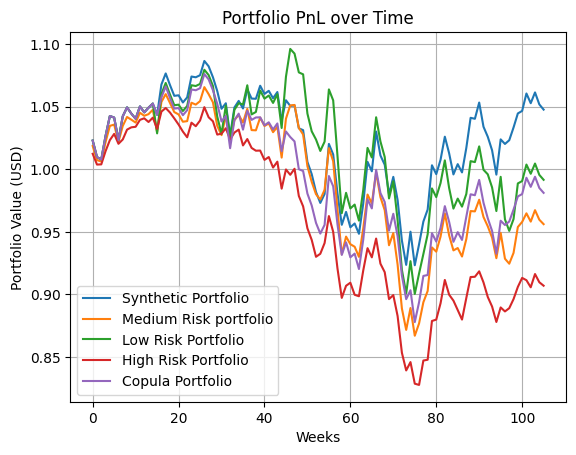

In [61]:
plt.plot(pnl)
plt.title('Portfolio PnL over Time')
plt.xlabel('Weeks')
plt.ylabel('Portfolio Value (USD)')
plt.grid(True)
plt.plot(pnl_bench_med)
plt.plot(pnl_bench_low)
plt.plot(pnl_bench_high)
plt.plot(pnl_copod)
plt.legend(['Synthetic Portfolio', 'Medium Risk portfolio', 'Low Risk Portfolio', 'High Risk Portfolio', 'Copula Portfolio'])

plt.show()

**Commentary on Portfolio PnL Over Time**

As anticipated, the three fixed-weight benchmark portfolios exhibit similar trends, with differences in scale reflecting their respective risk profiles. Their trajectories are consistent, underscoring the predictable nature of static allocation strategies.

Although the copula-based portfolio is built upon the best-performing individual anomaly detection model, it does not outperform the benchmark portfolios. Its performance aligns more closely with that of a medium-risk investment strategy, suggesting that while effective, the copula model may not fully capture dynamic market shifts.

In contrast, the toy portfolio—constructed using an ensemble voting mechanism—demonstrates superior performance. This suggests that the ensemble approach captures additional market signals not detected by individual models such as COPOD. One possible explanation lies in the ensemble’s ability to incorporate temporal patterns, which are overlooked in more static, distribution-based methods like COPOD.

This highlights a fundamental distinction: statistical methods such as COPOD focus primarily on cross-sectional data and distributional assumptions, whereas neural-network-based or ensemble methods can implicitly model temporal dependencies. As a result, incorporating time or intertemporal relationships appears to be a critical factor in enhancing anomaly detection and, by extension, portfolio performance.